# Exploring the basic functionalities of the Sequencer
This notebook will contain examples that show the basic functionalities of the Sequencer. The notebook starts with a simulation of a very simple dataset that contains a clear one-dimensional sequence. Then, I will show several examples of how to apply the Sequencer to this dataset and how to use its output and various derived parameters. In particular, the will show: <br>
1. **Basic Sequencer run:** application of the Sequencer, with default settings, to the dataset. I will show how to define the Sequencer object and how to execute the Sequencer. I will show how to extract the elongation and the resulting sequence, and how to visualize the ordered dataset. Then, I will show how to extract other properties of the algorithm, such as the estimators and scales, and intermediate elongations and sequences. <br>
2. **Basic Sequencer run with parallelization:** the Sequencer algorithm involves the calculation of a set of distance matrices for the different estimators and scales. For large datasets, this takes most of the computation time. In this example I will show how to estimate the distance matrices in parallel. <br>
2. **Non-default Sequencer setting:** application of the sequencer with non-default settings. I will show how to define the scale list, and how to change the print and output options of the sequencer. <br>
3. **Loading the distance matrix list from memory:** when applying the algorithm to the data, one can choose to save the calculated distance matrices per estimator and scale for future use. If the algorithm is used more than once for the same dataset, saving the calculated distance matrices and then loading them can save a lot of computation time. In this exmaple I will show how to load the distance matrix list into memory and avoid the time it takes to re-compute them (this becomes very important for large datasets!).

### Environment setup
Before we start, we need to make sure that all the required packages are installed. <br>
If you did not install the required packages, then you should either follow the instructions from the [README](https://github.com/dalya/Sequencer/blob/master/README.md) file, or you should uncomment the following cell:

In [1]:
#!conda install numpy scipy networkx matplotlib
#!pip install TheSequencer

In [2]:
# imports
%matplotlib inline

import numpy
import matplotlib.pyplot as plt

import sequencer

In [8]:
sequencer?

## Simulate a very simple dataset
I will start by simulating a very simple dataset that consists of 1D objects with a single pulse. The dataset will contain 20 objects, each of length 20. Each object will be composed of zero continuum and a single pulse with a varying location. The locations of the pulses in the different objects will form a clear one-dimensional sequence. <br>
The final dataset will be a shuffled version of the simulated dataset.

In [4]:
# construct the grid and the objects_list

grid = numpy.arange(20)
objects_list_simulated = []
objects_true_indices = numpy.arange(20) # the ordered indices

for i in range(20):
    y = numpy.zeros(20)
    y[i] = 1
    objects_list_simulated.append(y)
objects_list_simulated = numpy.array(objects_list_simulated)
    
numpy.random.shuffle(objects_true_indices)
objects_list_shuffled = objects_list_simulated[objects_true_indices, :]

**Input data visualization:** the dataset consists of 20 one-dimensional objects. I can plot each of the objects separately using 1D lines, where the relative height of each 1D line represents its relative order within the dataset. Alternatively, I can plot all the objects together as a matrix, using 2D image. In the following cells, I visualize the dataset using both methods.

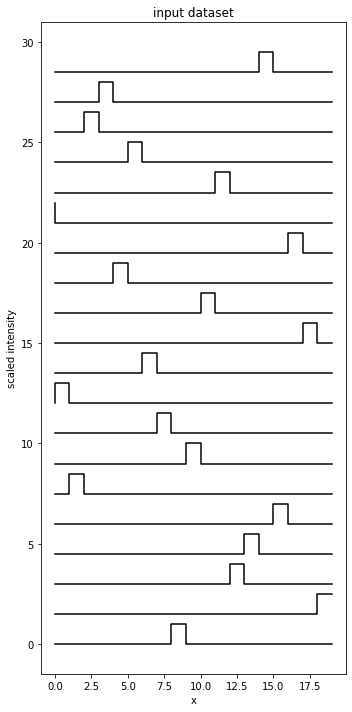

In [5]:
# visualize the input dataset as separate objects

plt.figure(1, figsize=(5, 10))
plt.title("input dataset")
for i, object_data in enumerate(objects_list_shuffled):
    object_data_scaled_y = object_data + i*1.5 # scale the objects so they will not be one on top of the other
    plt.step(grid, object_data_scaled_y, "k")
    
plt.xlabel("x")
plt.ylabel("scaled intensity")

plt.tight_layout()

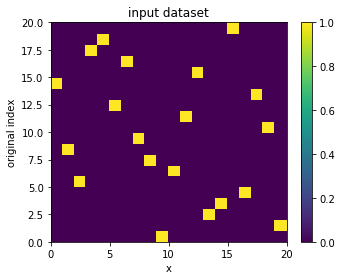

In [6]:
# visualize the input dataset 

plt.figure(1, figsize=(5, 4))
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.tight_layout()

## 1. Basic Sequencer run
I will start by applying the Sequencer to this dataset using its default settings. In the first cell, I define the list of distance metrics to consider. I then define the Sequencer object and apply it to the dataset.

In [7]:
# define the list of distance metrics to consider.
# I don't include the KL-Divergence because the dataset contains zero values
estimator_list = ['EMD', 'energy', 'L2']

# define the sequencer object with default parameters
seq = sequencer.Sequencer(grid, objects_list_shuffled, estimator_list)

# to execute the sequencer, we first need to define the output directory to which the different 
# outputs will be saved
output_path = "sequencer_output_directory"
final_elongation, final_sequence = seq.execute(output_path)

calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 0.027110815048217773 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 0.03598308563232422 seconds
calculating the distance matrices for estimator: L2, scale: 1
finished calculating this distance matrix list, it took: 0.0029649734497070312 seconds
dumped the distance matrix dictionaries to the file: sequencer_output_directory/distance_matrices.pkl
strating to sequence the different scales and estimators
in estimator: EMD, scale: 1
in estimator: energy, scale: 1
in estimator: L2, scale: 1
dumped the elongations to the file: sequencer_output_directory/elongations.pkl
dumped the full weighted distance matrix to the file: sequencer_output_directory/weighted_distance_matrix.pkl
dumped the sparse distance matrix to the file: <_io.BufferedWriter name='sequencer_output_directory/sparse_distance_m

/anaconda3/lib/python3.7/site-packages/sequencer/sequencer_.py:945: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


**Result:** The Sequencer was successfully applied to the dataset. I will now print the resulting elongation and sequence. The detected sequence vector represents the order in which the objects in the dataset should be ordered. <br>
After printing the elongation and resulting sequence, I will reorder the objects in the dataset according to the detected sequence, and will plot the ordered dataset.

The MST elongation:  20.0
The resulting sequence:  [ 1 10 13  4 19  3  2 15 11  6  0  7  9 16 12 18 17  5  8 14]


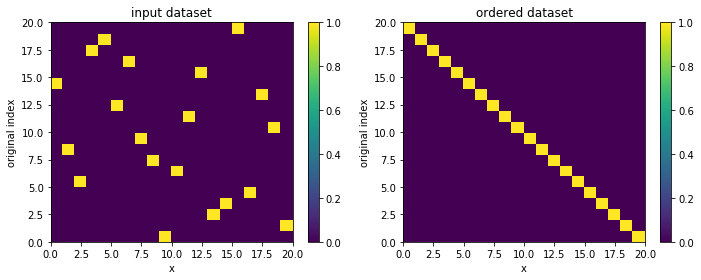

In [9]:
# print the final elongation
print("The MST elongation: ", final_elongation)

# print the resulting sequence
print("The resulting sequence: ", final_sequence)

# order the input dataset according to the detected sequence
objects_list_ordered = objects_list_shuffled[final_sequence]

# visualize the ordered dataset
plt.figure(1, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.subplot(1, 2, 2)
plt.title("ordered dataset")
plt.pcolormesh(objects_list_ordered)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.tight_layout()

**Results:** The sequencer successfully identified the one-dimensional trend in pulse location, and we obtained an elongation of 20, which represents a perfect sequence. <br>

Now, I will print several additional properties of the algorithm: I will start by extracting and printing the distance metrics and scales that were used to estimate the final sequence. Then, I will show how to extract the intermediate elongations that were calculated during the run, where each intermediate elongation corresponds to a particular distance metric and scale. By examining the intermediate elongations, we can learn which metric and scale was the most useful.

In [10]:
# extract the distance metric list and scale list
estimator_list = seq.estimator_list # distance metrics
scale_list = seq.scale_list # scales
print(estimator_list)
print(scale_list)

# print them one by one
print("The metrics and scales used by the code:")
for estimator_index, estimator_name in enumerate(estimator_list):
    scale_list_of_estimator = scale_list[estimator_index]
    for scale_index, scale_name in enumerate(scale_list_of_estimator):
        print("I used metric %s with scale %s" % (estimator_name, scale_name))

['EMD', 'energy', 'L2']
[[1], [1], [1]]
The metrics and scales used by the code:
I used metric EMD with scale 1
I used metric energy with scale 1
I used metric L2 with scale 1


Now let's examine the intermediate elongations obtained for each estimator and scale. To do that, there are several different options: <br>
1. The first is using the function ```seq.return_elongation_of_weighted_products(estimator_name, scale)```, which returns the intermediate elongation only for the given ```estimator_name``` and ```scale```. I will show this example first. <br> <br>
2. The second is using the function ```seq.return_elongation_of_weighted_products_all_metrics_and_scales()```, which resturns a list of all estimators, scales, and their corresponding intermediate elongations. I will show this example sceond. 

In [11]:
# first example
estimator_name = 'EMD'
scale = 1
print("Intermediate elongation for metric=%s and scale=%s: %s" % (estimator_name, scale, 
                                                                  seq.return_elongation_of_weighted_products(estimator_name, scale)))

# second example
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   elongation_list[i]))

Intermediate elongation for metric=EMD and scale=1: 20.0
metric=EMD, scale=1, elongation: 20.0
metric=energy, scale=1, elongation: 20.0
metric=L2, scale=1, elongation: 2.5


**What do we see?** when using the EMD or the Energy Distance, we find a maximal elongation of 20, which represents a perfect sequence. On the other hand, when using the Euclidean Distance (L2), we find a very low elongation of 2.5. This is expected since the Euclidean distance is not sensitive to horizontal shifts in the data, and thus the distance between all the objects in the sample is similar. Therefore, using the Euclidean Distance, we cannot recover the one-dimensional trend. The EMD and Energy Distance are sensitive to horizontal shifts, and thus they can be used to detect the sequence. <br>

To illustrate this point further, let's extract the intermediate sequences for each estimator and scale, and plot the resulting ordering. There are two functions that can be used to extract the intemediate sequences, which are very similar to the functions that extract the intermediate elongations: <br>
1. The first is using the function ```seq.return_sequence_of_weighted_products(estimator_name, scale)```, which returns the intermediate sequence only for the given ```estimator_name``` and ```scale```. I will not show this example. <br> <br>
2. The second is using the function ```seq.return_sequence_of_weighted_products_all_metrics_and_scales()```, which resturns a list of all estimators, scales, and their corresponding intermediate sequences. I will show only this example. 

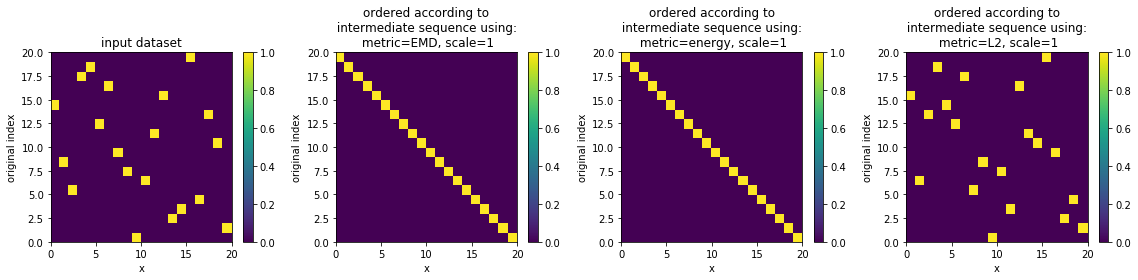

In [12]:
estimator_list, scale_list, sequence_list = seq.return_sequence_of_weighted_products_all_metrics_and_scales()

plt.figure(1, figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.subplot(1, 4, 2)
plt.title("ordered according to\n intermediate sequence using: \n metric=%s, scale=%s" % (estimator_list[0], scale_list[0]))
sequnce = sequence_list[0]
plt.pcolormesh(objects_list_shuffled[sequnce])
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.subplot(1, 4, 3)
plt.title("ordered according to\n intermediate sequence using: \n metric=%s, scale=%s" % (estimator_list[1], scale_list[1]))
sequnce = sequence_list[1]
plt.pcolormesh(objects_list_shuffled[sequnce])
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.subplot(1, 4, 4)
plt.title("ordered according to\n intermediate sequence using: \n metric=%s, scale=%s" % (estimator_list[2], scale_list[2]))
sequnce = sequence_list[2]
plt.pcolormesh(objects_list_shuffled[sequnce])
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.tight_layout()

As expected, we find a perfect sequence using the EMD and the Energy distance, and no sequence using the Euclidean Distance.

## 2. Basic Sequencer run with parallelization
Now I will apply the Sequencer to the same dataset, still with default settings, but I will show how to apply parallelization. To use parallelization, we can use the option ```to_use_parallelization=True``` in the function ```seq.execute()```. <br>
Obviously, for this tiny dataset, this will not imporve the computation time of the algorithm. For large datasets, users are encoraged to use this option to improve the computation time!

In [13]:
estimator_list = ['EMD', 'energy', 'L2']
seq = sequencer.Sequencer(grid, objects_list_shuffled, estimator_list)

output_path = "sequencer_output_directory"
final_elongation, final_sequence = seq.execute(output_path, to_use_parallelization=True)

Parallelization is ON. Number of cores: 4
calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 1.9860377311706543 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 0.04811215400695801 seconds
calculating the distance matrices for estimator: L2, scale: 1
finished calculating this distance matrix list, it took: 0.043263912200927734 seconds
dumped the distance matrix dictionaries to the file: sequencer_output_directory/distance_matrices.pkl
strating to sequence the different scales and estimators
in estimator: EMD, scale: 1
in estimator: energy, scale: 1
in estimator: L2, scale: 1
dumped the elongations to the file: sequencer_output_directory/elongations.pkl
dumped the full weighted distance matrix to the file: sequencer_output_directory/weighted_distance_matrix.pkl
dumped the sparse distance matrix to the file: <_io.BufferedWriter name='seque

The MST elongation:  20.0
The resulting sequence:  [ 1 10 13  4 19  3  2 15 11  6  0  7  9 16 12 18 17  5  8 14]


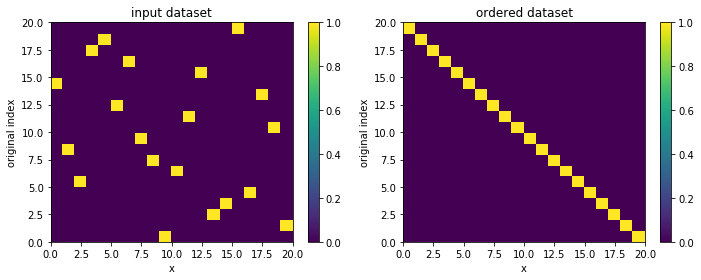

In [14]:
# print the final elongation
print("The MST elongation: ", final_elongation)

# print the resulting sequence
print("The resulting sequence: ", final_sequence)

# order the input dataset according to the detected sequence
objects_list_ordered = objects_list_shuffled[final_sequence]

# visualize the ordered dataset
plt.figure(1, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.subplot(1, 2, 2)
plt.title("ordered dataset")
plt.pcolormesh(objects_list_ordered)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.tight_layout()

## 3. Non-default Sequencer setting
In this example I will show how to change some of the default parameters of the Sequencer. <br>
I will start by showing how to define the scale list and will then examine the intermediate elongations for these new scales. Then, I will show how to change the default print and save settings of the Sequencer. <br>

In the next cell, I will define the distance metric list to include the EMD and the Energy Distance. For the scales, I will use scales 1, 2, and 4 for the EMD. A ```scale=2``` suggests that the algorithm will split each object into two parts, will compute distance matrices for objects in each given part, and will then aggregate all this information into a single weighted distance matrix. When ```scale=4```, the algorithm will split each object into 4 parts. For the Energy Distance, I will use the scales 4, 6, and 8. <br>
Since I am going to split each object into parts, but each object contains a single non-zero element, I will get chunks of objects which contain only zeros. It is impossible to estimate the distance between objects which contain only zeros (both using the EMD and the Energy distance). Therefore, I will add 1 to all the objects, such that the continuum will be 1, and the pulse will be 2. 

In [15]:
# define a new set of estimators and scales
estimator_list = ['EMD', 'energy']
scale_list = [[1, 2, 4], [4, 6, 8]]
objects_list_shuffled_scaled = objects_list_shuffled + 1
seq = sequencer.Sequencer(grid, objects_list_shuffled_scaled, estimator_list, scale_list=scale_list)

output_path = "sequencer_output_directory"
final_elongation, final_sequence = seq.execute(output_path)

calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 0.03733396530151367 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 0.03795981407165527 seconds
calculating the distance matrices for estimator: EMD, scale: 4
finished calculating this distance matrix list, it took: 0.0711362361907959 seconds
calculating the distance matrices for estimator: energy, scale: 4
finished calculating this distance matrix list, it took: 0.07441401481628418 seconds
calculating the distance matrices for estimator: energy, scale: 6
finished calculating this distance matrix list, it took: 0.09667587280273438 seconds
calculating the distance matrices for estimator: energy, scale: 8
finished calculating this distance matrix list, it took: 0.1391129493713379 seconds
dumped the distance matrix dictionaries to the file: sequencer_output_directory/distance_matrices.pkl
str

The MST elongation:  20.0
The resulting sequence:  [ 1 10 13  4 19  3  2 15 11  6  0  7  9 16 12 18 17  5  8 14]


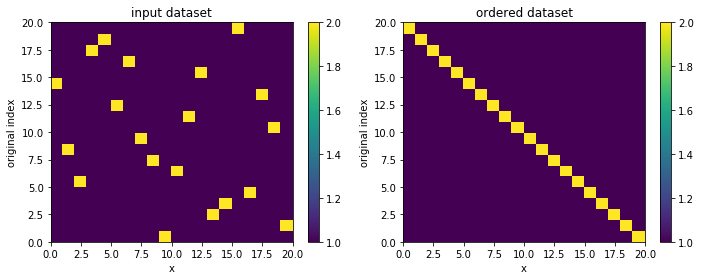

In [16]:
# print the final elongation
print("The MST elongation: ", final_elongation)

# print the resulting sequence
print("The resulting sequence: ", final_sequence)

# order the input dataset according to the detected sequence
objects_list_ordered = objects_list_shuffled_scaled[final_sequence]

# visualize the ordered dataset
plt.figure(1, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled_scaled)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.subplot(1, 2, 2)
plt.title("ordered dataset")
plt.pcolormesh(objects_list_ordered)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.tight_layout()

Now I want to examine the intermediate elongations obtained for the different distance metrics and scales:

In [17]:
print("intermediate elongations for the different metrics and scales:")
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   elongation_list[i]))

intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 20.0
metric=EMD, scale=2, elongation: 8.8
metric=EMD, scale=4, elongation: 3.9050000000000002
metric=energy, scale=4, elongation: 4.5200000000000005
metric=energy, scale=6, elongation: 3.8699999999999997
metric=energy, scale=8, elongation: 2.475


**What do we see?** we find a decreasing elongation with increasing scale. This means that as we divide these objects into more parts, it is more difficult for us to detect a sequence. This is rather expected: when we divide the objects into two parts, it means that in one of the parts, half of the objects will appear as constant vectors (because the pulse will be present in the other part), and constant vectors do not form a sequence. This means that in each part, only half of the objects will show a clear sequence, and half will not. This problem becomes worse as we increase the scale: when we split the objects into 4 parts, in each part only 20/4=5 objects will show a clear sequence, while the rest (15) will not! <br>

We see that the Sequencer can automatically detect the relevant scales of the problem. That is, it can detect the scales in which the strongest sequence signature is present. Although we used several scales which are not optimal, the final sequence is a perfect sequence with an elongation of 20. This is because the Sequencer gave larger weight to the best estimator+scale, which is EMD scale=1 in this case. In the other notebooks, you can find examples of datasets in which small-scale information is more important. <br><br>

**Averaging only the N best estimators:** although the Sequencer gives a larger weight to metrics+scales with larger elongations, we might be in a situtation where there is only one good metric+scale, and many irrelevant ones. In such case, it is possible that the perfect sequence will be dilluted by the many bad scales. To avoid this, we can set the Sequencer to take into account only the N best estimators (metrics+scales). Below, I will increase the number of the irrelevant scales even more to dillute the result on purpose. I will then show how to use the ```to_average_N_best_estimators``` option in the ```seq.execute()``` function to avoid this problem. 

In [18]:
# define a new set of estimators and scales
estimator_list = ['EMD']
scale_list = [[1, 2, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]
objects_list_shuffled_scaled = objects_list_shuffled + 1
seq = sequencer.Sequencer(grid, objects_list_shuffled_scaled, estimator_list, scale_list=scale_list)

output_path = "sequencer_output_directory"
final_elongation, final_sequence = seq.execute(output_path)

calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 0.030909299850463867 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 0.05317211151123047 seconds
calculating the distance matrices for estimator: EMD, scale: 10
finished calculating this distance matrix list, it took: 0.1807537078857422 seconds
calculating the distance matrices for estimator: EMD, scale: 11
finished calculating this distance matrix list, it took: 0.17563390731811523 seconds
calculating the distance matrices for estimator: EMD, scale: 12
finished calculating this distance matrix list, it took: 0.19835186004638672 seconds
calculating the distance matrices for estimator: EMD, scale: 13
finished calculating this distance matrix list, it took: 0.26401400566101074 seconds
calculating the distance matrices for estimator: EMD, scale: 14
finished calculating this distance matrix li

The MST elongation:  4.01
The resulting sequence:  [16 12 18 17 19 14 15 10  3 13 11  6  7  4  2  1  8  0  5  9]


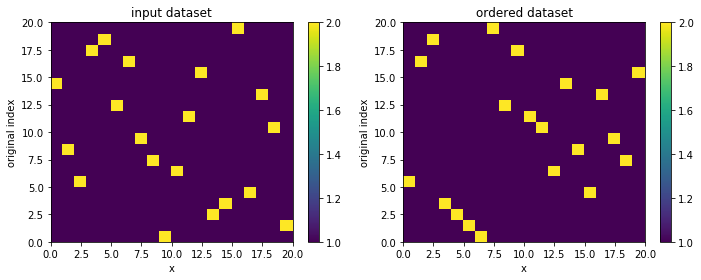

In [19]:
# print the final elongation
print("The MST elongation: ", final_elongation)

# print the resulting sequence
print("The resulting sequence: ", final_sequence)

# order the input dataset according to the detected sequence
objects_list_ordered = objects_list_shuffled_scaled[final_sequence]

# visualize the ordered dataset
plt.figure(1, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled_scaled)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.subplot(1, 2, 2)
plt.title("ordered dataset")
plt.pcolormesh(objects_list_ordered)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.tight_layout()

As expected, the largest scale (where there is a perfect sequence) is completely dilluted by all the irelevant scales I added to the run (10, 11, 12, 13, 14, 15, 16, 17, 18, 19). To illustrate this even more, let's print the intermediate elongations obtained for the different scales:

In [20]:
print("intermediate elongations for the different metrics and scales:")
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   elongation_list[i]))

intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 20.0
metric=EMD, scale=2, elongation: 8.8
metric=EMD, scale=10, elongation: 3.07
metric=EMD, scale=11, elongation: 2.6
metric=EMD, scale=12, elongation: 2.7
metric=EMD, scale=13, elongation: 3.6599999999999997
metric=EMD, scale=14, elongation: 3.8699999999999997
metric=EMD, scale=15, elongation: 4.01
metric=EMD, scale=16, elongation: 2.5
metric=EMD, scale=17, elongation: 3.16
metric=EMD, scale=18, elongation: 3.1
metric=EMD, scale=19, elongation: 2.08


To avoid this issue, we can set ```to_average_N_best_estimators=True``` in the ```seq.execute()``` function. 

In [21]:
estimator_list = ['EMD']
scale_list = [[1, 2, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]
objects_list_shuffled_scaled = objects_list_shuffled + 1
seq = sequencer.Sequencer(grid, objects_list_shuffled_scaled, estimator_list, scale_list=scale_list)

output_path = "sequencer_output_directory"
# set to_average_N_best_estimators=True, and number_of_best_estimators=2:
final_elongation, final_sequence = seq.execute(output_path, 
                                               to_average_N_best_estimators=True, 
                                              number_of_best_estimators=2)

calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 0.02833414077758789 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 0.05777883529663086 seconds
calculating the distance matrices for estimator: EMD, scale: 10
finished calculating this distance matrix list, it took: 0.174635648727417 seconds
calculating the distance matrices for estimator: EMD, scale: 11
finished calculating this distance matrix list, it took: 0.16789603233337402 seconds
calculating the distance matrices for estimator: EMD, scale: 12
finished calculating this distance matrix list, it took: 0.19635987281799316 seconds
calculating the distance matrices for estimator: EMD, scale: 13
finished calculating this distance matrix list, it took: 0.20022130012512207 seconds
calculating the distance matrices for estimator: EMD, scale: 14
finished calculating this distance matrix list

The MST elongation:  20.0
The resulting sequence:  [ 1 10 13  4 19  3  2 15 11  6  0  7  9 16 12 18 17  5  8 14]


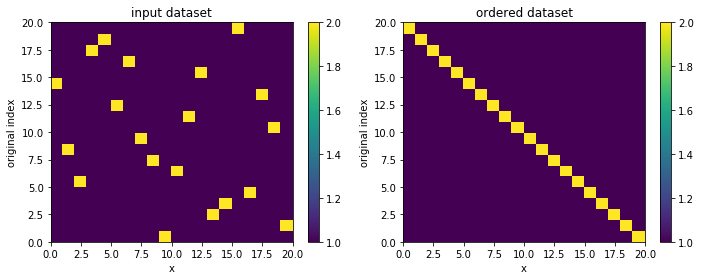

In [22]:
# print the final elongation
print("The MST elongation: ", final_elongation)

# print the resulting sequence
print("The resulting sequence: ", final_sequence)

# order the input dataset according to the detected sequence
objects_list_ordered = objects_list_shuffled_scaled[final_sequence]

# visualize the ordered dataset
plt.figure(1, figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled_scaled)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.subplot(1, 2, 2)
plt.title("ordered dataset")
plt.pcolormesh(objects_list_ordered)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("original index")

plt.tight_layout()

As we can see, limiting the number of estimators only to the best two improved the result dramatically! <br><br>

**Limiting the printing options of the Sequencer:** as you probably noticed, when applying the Sequencer to the data, the code prints a lot of stuff. Although I find it useful, especially when the distance matrices calculations take a lot of time, you might find it annoying. You can stop the printing by setting ```to_print_progress=False``` in the ```seq.execute()``` option:

In [23]:
estimator_list = ['EMD']
scale_list = [[1, 2]]
objects_list_shuffled_scaled = objects_list_shuffled + 1
seq = sequencer.Sequencer(grid, objects_list_shuffled_scaled, estimator_list, scale_list=scale_list)

output_path = "sequencer_output_directory"
# set to_print_progress=False
final_elongation, final_sequence = seq.execute(output_path, 
                                               to_print_progress=False)

In [24]:
# print the final elongation
print("The MST elongation: ", final_elongation)

# print the resulting sequence
print("The resulting sequence: ", final_sequence)

The MST elongation:  20.0
The resulting sequence:  [ 1 10 13  4 19  3  2 15 11  6  0  7  9 16 12 18 17  5  8 14]


## 4. Loading the distance matrix list from memory
For large datasets, the most computationally-demanding part of the code is the calculation of the distance matrices per metric and scale. In some cases, we will find ourselves executing the same code with the same data several times. In such cases, we can avoid the re-calculation of the distance matrices, if they were already calculated and saved in a previous run. In the next several cells, I will show how to do this. <br>
I will start by executing the Sequencer using many scales and estimators, where the default option ```to_save_distance_matrices=True``` of the function ```seq.execute()``` ensures that all the matrices were saved:

In [25]:
estimator_list = ['EMD', 'energy', 'L2']
scale_list = [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
objects_list_shuffled_scaled = objects_list_shuffled + 1
seq = sequencer.Sequencer(grid, objects_list_shuffled_scaled, estimator_list, scale_list=scale_list)

output_path = "sequencer_output_directory"
# set to_print_progress=False
final_elongation, final_sequence = seq.execute(output_path)

calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 0.032525062561035156 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 0.053312063217163086 seconds
calculating the distance matrices for estimator: EMD, scale: 3
finished calculating this distance matrix list, it took: 0.06593489646911621 seconds
calculating the distance matrices for estimator: EMD, scale: 4
finished calculating this distance matrix list, it took: 0.06364226341247559 seconds
calculating the distance matrices for estimator: EMD, scale: 5
finished calculating this distance matrix list, it took: 0.0763390064239502 seconds
calculating the distance matrices for estimator: EMD, scale: 6
finished calculating this distance matrix list, it took: 0.09575295448303223 seconds
calculating the distance matrices for estimator: EMD, scale: 7
finished calculating this distance matrix list, 

In [26]:
%ls sequencer_output_directory/

distance_matrices.pkl         log_file.txt
elongations.pkl               sparse_distance_matrix.pkl
final_products.pkl            weighted_distance_matrix.pkl


The last command shows what kind of files are saved during the run of the Sequencer: <br>
1. The file ```log_file.txt``` is a log file that contains all the things that were printed by the Sequencer. <br>
2. The file ```elongations.pkl``` is a python pickle file of a dictionary that contains all the intermediate elongations and sequences obtained during the computation. <br>
3. The file ```final_products.pkl``` is a python pickle file containing the final elongation and the final detected sequence. <br>
4. The file ```distance_matrices.pkl``` is a python pickle file of a dictionary that contains all the distance matrices estimated during the run. This is exactly the file that we need in order to load the matrices into memory. <br>
5. The file ```weighted_distance_matrix.pkl``` is a dicitionary containing all the weighted distance matrices per scale and estimator (these are the result of the weighted average over the different chunks for a given scale). See the paper for additional details. <br>
6. The file ```sparse_distance_matrix.pkl``` is the final, sparse, distance matrix from which the final sequence is extracted. This matrix is the inverse of the proximity matrix, into which all the intermediate sequences were populated. See the paper for additional details. <br><br>

Say that we want to execute the Sequencer again, using the same scales and metrics, but we do not want to recompute all the matrices. To avoid recomputing the matrices, we will change the following parameters:<br>
1. ```to_calculate_distance_matrices=True``` -> ```to_calculate_distance_matrices=False```
2. ```to_save_distance_matrices=True``` -> ```to_save_distance_matrices=False```
3. ```distance_matrices_inpath=None``` -> ```distance_matrices_inpath="sequencer_output_directory/distance_matrices.pkl"```

In [27]:
estimator_list = ['EMD', 'energy', 'L2']
scale_list = [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
objects_list_shuffled_scaled = objects_list_shuffled + 1
seq = sequencer.Sequencer(grid, objects_list_shuffled_scaled, estimator_list, scale_list=scale_list)

output_path = "sequencer_output_directory"
# set to_print_progress=False
final_elongation, final_sequence = seq.execute(output_path, 
                                               to_calculate_distance_matrices=False,
                                               to_save_distance_matrices=False,
                                               distance_matrices_inpath="sequencer_output_directory/distance_matrices.pkl")

strating to sequence the different scales and estimators
in estimator: EMD, scale: 1
in estimator: EMD, scale: 2
in estimator: EMD, scale: 3
in estimator: EMD, scale: 4
in estimator: EMD, scale: 5
in estimator: EMD, scale: 6
in estimator: EMD, scale: 7
in estimator: EMD, scale: 8
in estimator: EMD, scale: 9
in estimator: EMD, scale: 10
in estimator: energy, scale: 1
in estimator: energy, scale: 2
in estimator: energy, scale: 3
in estimator: energy, scale: 4
in estimator: energy, scale: 5
in estimator: energy, scale: 6
in estimator: energy, scale: 7
in estimator: energy, scale: 8
in estimator: energy, scale: 9
in estimator: energy, scale: 10
in estimator: L2, scale: 1
in estimator: L2, scale: 2
in estimator: L2, scale: 3
in estimator: L2, scale: 4
in estimator: L2, scale: 5
in estimator: L2, scale: 6
in estimator: L2, scale: 7
in estimator: L2, scale: 8
in estimator: L2, scale: 9
in estimator: L2, scale: 10
dumped the elongations to the file: sequencer_output_directory/elongations.pkl
d

We can see from the prints that the Sequencer did not calculate the distance matrices, but instead loaded them and started from the sequencing of the different scales and estimators. <br>

The option of loading the distance matrices into memory can also be used when we're interested in a subset of all the metrics and scales that we have computed. For example, in the next cell, I want to sequence only using EMD+scale=1, energy+scale=2, and L2+scale=10:

In [28]:
estimator_list = ['EMD', 'energy', 'L2']
scale_list = [[1], [2], [10]]
objects_list_shuffled_scaled = objects_list_shuffled + 1
seq = sequencer.Sequencer(grid, objects_list_shuffled_scaled, estimator_list, scale_list=scale_list)

output_path = "sequencer_output_directory"
# set to_print_progress=False
final_elongation, final_sequence = seq.execute(output_path, 
                                               to_calculate_distance_matrices=False,
                                               to_save_distance_matrices=False,
                                               distance_matrices_inpath="sequencer_output_directory/distance_matrices.pkl")

strating to sequence the different scales and estimators
in estimator: EMD, scale: 1
in estimator: energy, scale: 2
in estimator: L2, scale: 10
dumped the elongations to the file: sequencer_output_directory/elongations.pkl
dumped the full weighted distance matrix to the file: sequencer_output_directory/weighted_distance_matrix.pkl
dumped the sparse distance matrix to the file: <_io.BufferedWriter name='sequencer_output_directory/sparse_distance_matrix.pkl'>
dumped the final sequences and elongation to the file: <_io.BufferedWriter name='sequencer_output_directory/final_products.pkl'>


When using a subset of metrics and scales like we just did, we need to be careful not to set ```to_save_distance_matrices=True```. If we do set ```to_save_distance_matrices=True```, then the Sequencer will save a new list of matrices that corresponds only to the three combinations: EMD+scale=1, energy+scale=2, and L2+scale=10, and we will loose all the rest of the matrices!